In [74]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.converters import circuit_to_instruction
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector

#from qiskit import IBMQ, Aer

In [75]:
def rot_surf_code(n: int) -> QuantumCircuit:
    qr = QuantumRegister(9*n, "q")
    qc = QuantumCircuit(qr)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    return qc

def rot_surf_code_with_3ancilla(n: int) -> QuantumCircuit: 
    qr = QuantumRegister(9*n+2, "q")
    qc = QuantumCircuit(qr)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    qr1 = QuantumRegister(1)                
    cbit = ClassicalRegister(1)
    qc1 = QuantumCircuit(qr1,cbit)                  #qubit m für T-Gate!
    return qc, qc1

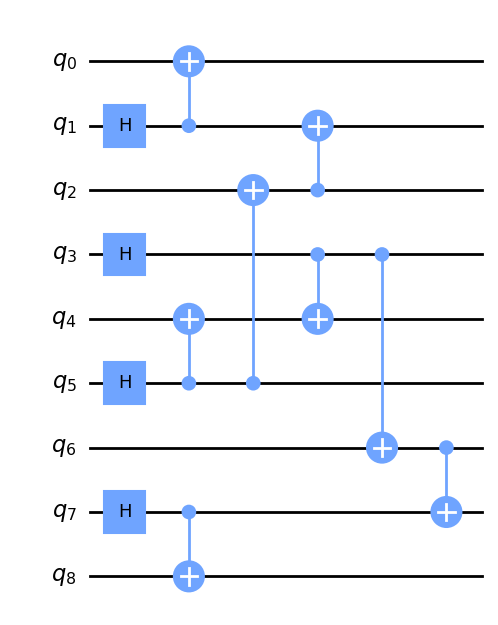

In [76]:
qc = rot_surf_code(1)
qc.draw("mpl", style="clifford")

In [77]:
def logical_operators(qc: QuantumCircuit, hadamard = False) -> Operator:                          #Gibt mir X_L und Z_L als Observablen raus, damit ich deren Eigenwert bestimmen kann für den GESAMTEN Circuit
    size = qc.num_qubits
    n = int(size/9)
    string_x = ""
    string_z = ""
    if hadamard:
        for i in range(n):
            string_x += "IIIXXXIII"
            string_z += "IZIIZIIZI"
    else:
        for i in range(n):
            string_x += "IXIIXIIXI"
            string_z += "IIIZZZIII"
    logical_x = SparsePauliOp.from_list([(string_x,1.0)])                           #Zahl "1.0" ist nur ein Vorfaktor
    logical_z = SparsePauliOp.from_list([(string_z,1.0)])
    return logical_x, logical_z

def logical_operators_with_2ancilla(qc: QuantumCircuit, hadamard = False, pos = 0) -> Operator:              #Gibt mir X_L und Z_L nur für den ersten logical qubit!!!
    if pos == 0:
        string_x = "II"+"IIIIIIIII"  
        string_z = "II"+"IIIIIIIII"
        size = qc.num_qubits
        n = int(size/9)
        if hadamard:
            for i in range(n-2):
                string_x = "IIIIIIIII"
                string_z = "IIIIIIIII"
            string_x += "IIIXXXIII"
            string_z += "IZIIZIIZI"
        else:
            for i in range(n-2):
                string_x = "IIIIIIIII"
                string_z = "IIIIIIIII"
            string_x += "IXIIXIIXI"
            string_z += "IIIZZZIII"
        logical_x = SparsePauliOp.from_list([(string_x,1.0)])                           #Zahl "1.0" ist nur ein Vorfaktor
        logical_z = SparsePauliOp.from_list([(string_z,1.0)])
    elif pos == 1:
        string_x = "II"
        string_z = "II"
        size = qc.num_qubits
        n = int(size/9)
        if hadamard:
            for i in range(n-2):
                string_x = "IIIIIIIII"
                string_z = "IIIIIIIII"
            string_x += "IIIXXXIII"
            string_z += "IZIIZIIZI"
        else:
            for i in range(n-2):
                string_x = "IIIIIIIII"
                string_z = "IIIIIIIII"
            string_x += "IXIIXIIXI"
            string_z += "IIIZZZIII"
        string_x += "IIIIIIIII"  
        string_z += "IIIIIIIII"
        logical_x = SparsePauliOp.from_list([(string_x,1.0)])                           #Zahl "1.0" ist nur ein Vorfaktor
        logical_z = SparsePauliOp.from_list([(string_z,1.0)])
    return logical_x, logical_z

def logical_operators_first_qubit(qc: QuantumCircuit, hadamard = False) -> Operator:              #Gibt mir X_L und Z_L nur für den ersten logical qubit!!!
    string_x = "IIIIIIIII"  
    string_z = "IIIIIIIII"
    size = qc.num_qubits
    n = int(size/9)
    if hadamard:
        for i in range(n-2):
            string_x = "IIIIIIIII"
            string_z = "IIIIIIIII"
        string_x += "IIIXXXIII"
        string_z += "IZIIZIIZI"
    else:
        for i in range(n-2):
            string_x = "IIIIIIIII"
            string_z = "IIIIIIIII"
        string_x += "IXIIXIIXI"
        string_z += "IIIZZZIII"
    logical_x = SparsePauliOp.from_list([(string_x,1.0)])                           #Zahl "1.0" ist nur ein Vorfaktor
    logical_z = SparsePauliOp.from_list([(string_z,1.0)])
    return logical_x, logical_z

def estimate_observables(circuit: QuantumCircuit, observables: list):
    estimator = StatevectorEstimator()
    pub = (circuit, observables)
    job = estimator.run([pub])
    result = job.result()[0]
    return result

def X_L(circuit: QuantumCircuit, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    if type(n) == int:
        circuit.x(9*n+1)
        circuit.x(9*n+4)
        circuit.x(9*n+7)
    elif type(n) == list:
        for i in n:
            circuit.x(9*i+1)
            circuit.x(9*i+4)
            circuit.x(9*i+7)
    return circuit

def Z_L(circuit: QuantumCircuit, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    if type(n) == int:
        circuit.z(9*n+3)
        circuit.z(9*n+4)
        circuit.z(9*n+5)
    elif type(n) == list:
        for i in n:
            circuit.z(9*i+3)
            circuit.z(9*i+4)
            circuit.z(9*i+5)
    return circuit

def Hadmard(circuit: QuantumCircuit, n=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    if type(n) == int:
        for i in range(9):
            circuit.h(9*n+i)
    return circuit

def X_L_rot(circuit: QuantumCircuit, n=0):            #X_L nach einem H-Gate
    if type(n) == int:
        circuit.x(9*n+3)
        circuit.x(9*n+4)
        circuit.x(9*n+5)
    elif type(n) == list:
        for i in n:
            circuit.x(9*i+3)
            circuit.x(9*i+4)
            circuit.x(9*i+5)
    return circuit

def Z_L_rot(circuit: QuantumCircuit, n=0):            #Z_L nach einem H-Gate
    if type(n) == int:
        circuit.z(9*n+1)
        circuit.z(9*n+4)
        circuit.z(9*n+7)
    elif type(n) == list:
        for i in n:
            circuit.z(9*i+1)
            circuit.z(9*i+4)
            circuit.z(9*i+7)
    return circuit

def CNOT(circuit:QuantumCircuit, control: int):               #ich programmiers jetzt mal nur für den Spezialfall von 2 Circuits
    if control == 0:
        for i in range(9):
            circuit.cx(control_qubit=i,target_qubit=9+i)
    elif control == 1: 
        for i in range(9):
            circuit.cx(control_qubit=9+i,target_qubit=i)
    else:
        return print("Noch nicht gecoded!")
    return circuit

def logical_S(circuit: QuantumCircuit, n=0):
    for i in range(9):
        circuit.z(9*n+i)
        circuit.s(9*n+i)
    return circuit

def adjoint_logical_S(circuit: QuantumCircuit, n=0):
    for i in range(9):
        circuit.z(9*n+i)
        circuit.sdg(9*n+i)
    return circuit

def log_T_Gate(circuit: QuantumCircuit, m: QuantumCircuit, hadamard: False, pos = 0):           #Für den Spezialfall mit zwei logischen Quibts (0_L und phi_L=1_L) und einem ancilla qubits --> 19 total physical qubits
    ancilla = circuit.num_qubits-1
    circuit.reset(ancilla)
    circuit.h(ancilla)
    circuit.t(ancilla)
    if pos == 0:
        if hadamard:
            _, z_l = logical_operators_with_2ancilla(circuit, True)
        else:
            _, z_l = logical_operators_with_2ancilla(circuit, False)
    elif pos == 1:
        if hadamard:
            _, z_l = logical_operators_with_2ancilla(circuit, True, pos = 1)
        else:
            _, z_l = logical_operators_with_2ancilla(circuit, False, pos = 1)
    else:
        return print("Noch nicht gecoded!")
    result = estimate_observables(circuit, [z_l])
    print("Result vom Z measurement des logical qubits: ", result.data.evs[0])
    if int(np.round(result.data.evs[0],2)) == -1:
        circuit.x(ancilla-2)

    circuit.cx(ancilla-2, ancilla-1)
    circuit.cs(ancilla, ancilla-1)
    circuit.measure(ancilla-1,0)
    with circuit.if_test((0,1)):
        circuit = logical_S(circuit, pos)

    circuit.h(ancilla)
    circuit.measure(ancilla,0)
    with qc.if_test((0,1)):
        circuit = Z_L(circuit, pos)
        print("Result vom X measurement: -1")
    return circuit

def adjoint_log_T_Gate(circuit: QuantumCircuit, hadamard: False, pos = 0):           #Für den Spezialfall mit zwei logischen Quibts (0_L und phi_L=1_L) und einem ancilla qubits --> 19 total physical qubits
    ancilla = circuit.num_qubits-1
    circuit.reset(ancilla)
    circuit.h(ancilla)
    circuit.tdg(ancilla)
    if pos == 0:
        if hadamard:
            _, z_l = logical_operators_with_3ancilla(circuit, True)
        else:
            _, z_l = logical_operators_with_3ancilla(circuit, False)
    elif pos == 1:
        if hadamard:
            _, z_l = logical_operators_with_3ancilla(circuit, True, pos = 1)
        else:
            _, z_l = logical_operators_with_3ancilla(circuit, False, pos = 1)
    else:
        return print("Noch nicht gecoded!")
    result = estimate_observables(circuit, [z_l])
    print("Result vom Z measurement des logical qubits: ", result.data.evs[0])
    if int(np.round(result.data.evs[0],2)) == -1:
        circuit.x(ancilla-2)

    circuit.cx(ancilla-2, ancilla-1)
    circuit.cs(ancilla, ancilla-1)
    circuit.measure(ancilla-1,0)
    with circuit.if_test((0,1)):
        circuit = adjoint_logical_S(circuit, pos)

    circuit.h(ancilla)
    circuit.measure(ancilla,0)
    with qc.if_test((0,1)):
        circuit = Z_L(circuit, pos)
        print("Result vom X measurement: -1")
    return circuit
    
def log_controlled_S(circuit: QuantumCircuit, control: int, target: int) -> QuantumCircuit:
    qc = log_T_Gate(circuit, True, pos = control)
    qc = log_T_Gate(qc, False, pos = target)
    qc = CNOT(qc, control)
    qc = adjoint_log_T_Gate(qc, False, pos = target) 
    qc = CNOT(qc, control)
    return qc


In [78]:
qc = rot_surf_code(1)

x_l, z_l = logical_operators(qc)

qc = X_L(qc)

result = estimate_observables(qc, [x_l,z_l])
print("Erwartungswert von X_L : ",result.data.evs[0])
print("Erwartungswert von Z_L : ",result.data.evs[1])
#result.data.stds
# for idx, pauli in enumerate([x_l,z_l]):
#     plt.plot(result.data.evs[idx], label=pauli)
# plt.legend()

Erwartungswert von X_L :  0.0
Erwartungswert von Z_L :  -0.9999999999999992


In [79]:
qc = rot_surf_code(2)

x_l, z_l = logical_operators_first_qubit(qc)

#qc = X_L(qc)

qc = X_L(qc,1)

qc = CNOT(qc,1)

result = estimate_observables(qc, [x_l,z_l])
print("Erwartungswert von X_L vom ersten log. Qubit : ",result.data.evs[0])
print("Erwartungswert von Z_L vom ersten log. Qubit : ",result.data.evs[1])

Erwartungswert von X_L vom ersten log. Qubit :  0.0
Erwartungswert von Z_L vom ersten log. Qubit :  -0.9999999999999998


In [80]:
qc = rot_surf_code(1)

x_l, z_l = logical_operators(qc, True)

qc = Hadmard(qc)


# for j in range(101):
#     for i in range(qc.num_qubits):
#         qc.h(i)

qc = Z_L_rot(qc)

result = estimate_observables(qc, [x_l,z_l])
print("Erwartungswert von X_L : ",result.data.evs[0])
print("Erwartungswert von Z_L : ",result.data.evs[1])

Erwartungswert von X_L :  -0.9999999999999981
Erwartungswert von Z_L :  0.0


In [82]:
bitstring = ""

qc = rot_surf_code_with_3ancilla(2)

qc = X_L(qc, 1)

qc = Hadmard(qc, 0)

qc = log_controlled_S(qc, 0, 1)
qc = log_controlled_S(qc, 0, 1)

qc = Hadmard(qc,0)

x_l, z_l = logical_operators_with_3ancilla(qc, False)

result = estimate_observables(qc, [z_l]).data.evs[0]

print("Erstes Bit (hier sollte -1 rauskommen): ", result)

if int(np.round(result,3)) == -1:
    bitstring += "1"
elif int(np.round(result,3)) == 1:
    bitstring += "0"

for i in range(19):
    qc.reset(i)

# qc = X_L(qc, 1)
# qc = Hadmard(qc, 0)
# qc = log_controlled_S(qc, 0, 1)

# qc = logical_S(qc,0)
# qc = Hadmard(qc,0)

# x_l, z_l = logical_operators_first_qubit_with_ancilla(qc, False)

# result = estimate_observables(qc, [z_l]).data.evs[0]
# print("Zweiter Bit (hier sollte +1 rauskommen): ", result)

# if int(np.round(result,3)) == -1:
#     bitstring += "1"
# elif int(np.round(result,3)) == 1:
#     bitstring += "0"

# print(bitstring)

# sim = AerSimulator()
# job = sim.run(qc, shots=100)
# result = job.result()
# counts = result.get_counts()
# print(counts)

Result vom Z measurement des logical qubits:  0.0
Result vom X measurement: -1


QiskitError: 'Cannot apply instruction with classical bits: measure'

{'101': 100}


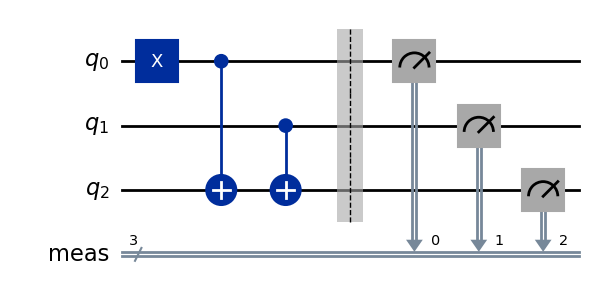

In [118]:
qr   = QuantumRegister(3,"q")
cr   = ClassicalRegister(3,"c")
circ = QuantumCircuit(qr)

# circ.h(qr[0])
# circ.h(qr[1])
# #circ.h(qr[2])

# circ.measure(qr[0],0)

# with circ.if_test((0,1)):
#     circ.z(1)
#     circ.h(1)

# circ.measure(qr[1],1)
# circ.measure(qr[2],2)

# sim = AerSimulator()
# job = sim.run(circ, shots=100)
# result = job.result()
# counts = result.get_counts()
# print(counts)

# circ.reset(qr[0])

circ.x(0)
#circ.x(1)

circ.cx(0,2)
circ.cx(1,2)
#circ.measure(2)
circ.measure_all()

sim = AerSimulator()
job = sim.run(circ, shots=100)
result = job.result()
counts = result.get_counts()
print(counts)

circ.draw("mpl")